In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from ast import literal_eval
import matplotlib.pyplot as plt

# functions for pipeline

In [36]:
def drop_categories(df):
    # this function drops all categories of API output which are irrelevant for prediction
    
    # possibly also drop controller_support, fullgame columns
    df.drop("dlc",axis=1, inplace=True)
    df.drop("review_score_desc",axis=1, inplace=True)
    df.drop("legal_notice",axis=1, inplace=True)
    df.drop("recommendations",axis=1, inplace=True)
    df.drop("ext_user_account_notice",axis=1, inplace=True)
    df.drop("reviews",axis=1, inplace=True)
    df.drop("metacritic",axis=1, inplace=True)
    df.drop("demos",axis=1, inplace=True)
    df.drop("drm_notice",axis=1, inplace=True)
    df.drop("alternate_appid",axis=1, inplace=True)
    df.drop("screenshots",axis=1, inplace=True)
    df.drop("movies",axis=1, inplace=True)
    df.drop("support_info",axis=1, inplace=True)
    df.drop("background",axis=1, inplace=True)
    df.drop("background_raw",axis=1, inplace=True)
    df.drop("content_descriptors",axis=1, inplace=True)
    df.drop("packages",axis=1, inplace=True)
    df.drop("package_groups",axis=1, inplace=True)
    df.drop("num_reviews",axis=1, inplace=True)
    df.drop("developers",axis=1, inplace=True)
    df.drop("achievements",axis=1, inplace=True)
    df.drop("detailed_description",axis=1, inplace=True)
    df.drop("about_the_game",axis=1, inplace=True)
    df.drop("supported_languages",axis=1, inplace=True)
    df.drop("header_image",axis=1, inplace=True)
    df.drop("website",axis=1, inplace=True)


In [37]:
def drop_few_review_games(df, num_reviews=50):
    # drop games with less than num_reviews reviews. also reset the index after dropping rows
    df =  df.loc[lambda df: df['total_reviews'] >= num_reviews, :].reset_index(drop=True)
    return df

In [38]:
def clean_price(df):
    # Clean up "price_overview" output of API and add new column "price"
    # use price without discounts(initial)
    
    df["price"] = 0
    
    # iterate through rows
    for index, row in df.iterrows():
        
        # if free to play, keep 0
        if not row.is_free:
            
            # try to read the entry as a dictionary
            try:
                dict = literal_eval(str(row.price_overview).replace("''",'None'))
            
            # if not possible delete row
            except: 
                df.drop(index, inplace=True)
            
            # if possible
            else: 
                
                # if currency is not EUR
                if dict["currency"] != "EUR":
                    
                    # delete row
                    df.drop(index, inplace=True)
            
                # get price
                else:
                    df["price"].loc[index] = dict["initial"]
                    
    df = df.drop('price_overview', axis=1).reset_index(drop=True)
    
    return df


In [39]:
def drop_high_price_games(df, max_price=200):
    # drops few outlier games which have unreasonably high prices. max price is price in euros (price/100)
    df=  df.loc[lambda df: df['price']/100 <= max_price, :].reset_index(drop=True)
    return df

In [47]:
def clean_genres(df):
    # this function takes the API output of the column genres and cleans it up
    #genres are shown in a list in new column "genres_clean" in output dataframe
    
    df["genres_clean"] = ""
    
    # iterate through rows
    for index, row in df.iterrows():
            
        # try to read the entry as a dictionary
        try:
            dict = literal_eval(str(row.genres).replace("''",'None'))
        
        # if not possible delete row
        except: 
            df.drop(index, inplace=True)
        
        # if possible
        else:
             
            genres = []
            
            for j in range(len(dict)):
                genres.append(dict[j]["description"])
            
            df["genres_clean"].loc[index] = np.array(genres)
                    
    df.drop('genres', axis=1, inplace=True)
    df.reset_index(inplace=True)
    df.drop("index", axis=1, inplace=True)

    return df

In [41]:
def get_genres_set(df):
    # this function iterates through the new column "genres_clean" and return the set of unique genres contained in the dataframe
    G = []
    
    for idx,row in df.iterrows():
        
        for j in range(len(row.genres_clean)):
            G.append(row.genres_clean[j])
    
    return list(set(G))
        

In [42]:
def one_hot_encode_genres(df,G):
    # this function creates a new column for each unique genre in the dataframe to one-hot-encode it.
    for j in G:
        df[j] = 0
    
    for idx,row in df.iterrows():
        for genre in row.genres_clean:
            df[genre].loc[idx] = 1
    return df

# test pipeline

In [62]:
df = pd.read_csv("raw_data.csv", index_col=0, low_memory=False)

In [63]:
# clean and pre-process data
drop_categories(df)
df = drop_few_review_games(df, num_reviews=50)
df = clean_price(df)
df = drop_high_price_games(df, max_price=200)
df = clean_genres(df)
G = get_genres_set(df)
df = one_hot_encode_genres(df,G)

C:\Users\Marco\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Marco\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [64]:
df

,appid,name,review_score,total_positive,total_negative,total_reviews,type,required_age,is_free,short_description,...,Strategy,Web Publishing,Game Development,Software Training,Sexual Content,Animation & Modeling,Action,Экшены,Nudity,Design & Illustration
0,1648390,ScooterFlow,8,446,21,467,game,0,False,The world’s most realistic freestyle scooter g...,...,0,0,0,0,0,0,0,0,0,0
1,1648610,Malum,6,146,53,199,game,0,False,Malum is the premier C-list horror game. Run f...,...,0,0,0,0,0,0,1,0,0,0
2,1647962,Hell Let Loose – Lethal Tide,8,70,6,76,dlc,0,False,Unlock access to the Lethal Tide DLC.,...,1,0,0,0,0,0,1,0,0,0
3,1647550,NEO: The World Ends with You,8,224,11,235,game,0,False,&quot;Only the possibility of you can change o...,...,0,0,0,0,0,0,1,0,0,0
4,1647730,Zool Redimensioned,8,68,2,70,game,0,False,The Ninja of the Nth Dimension is back! Explor...,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2431,3510,Amazing Adventures: The Lost Tomb,8,44,9,53,game,0,False,You are an adventure seeker who travels the wo...,...,0,0,0,0,0,0,0,0,0,0
2432,2800,X2: The Threat,6,142,38,180,game,0,False,X²: The Threat is of a new generation of space...,...,1,0,0,0,0,0,0,0,0,0
2433,17470,Dead Space (2008),8,8843,938,9781,game,0,False,"You are Isaac Clarke, an engineer on the space...",...,0,0,0,0,0,0,1,0,0,0
2434,758320,Cursed Lands,6,60,22,82,game,0,False,Defeat the evil lurking in Castle Of N'Mar in ...,...,0,0,0,0,0,0,0,0,0,0


In [46]:
df.to_csv('clean_data.csv')
df

,index,appid,name,review_score,total_positive,total_negative,total_reviews,type,required_age,is_free,...,Strategy,Web Publishing,Game Development,Software Training,Sexual Content,Animation & Modeling,Action,Экшены,Nudity,Design & Illustration
0,0,1648390,ScooterFlow,8,446,21,467,game,0,False,...,0,0,0,0,0,0,0,0,0,0
1,1,1648610,Malum,6,146,53,199,game,0,False,...,0,0,0,0,0,0,1,0,0,0
2,2,1647962,Hell Let Loose – Lethal Tide,8,70,6,76,dlc,0,False,...,1,0,0,0,0,0,1,0,0,0
3,3,1647550,NEO: The World Ends with You,8,224,11,235,game,0,False,...,0,0,0,0,0,0,1,0,0,0
4,4,1647730,Zool Redimensioned,8,68,2,70,game,0,False,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2431,2436,3510,Amazing Adventures: The Lost Tomb,8,44,9,53,game,0,False,...,0,0,0,0,0,0,0,0,0,0
2432,2437,2800,X2: The Threat,6,142,38,180,game,0,False,...,1,0,0,0,0,0,0,0,0,0
2433,2438,17470,Dead Space (2008),8,8843,938,9781,game,0,False,...,0,0,0,0,0,0,1,0,0,0
2434,2439,758320,Cursed Lands,6,60,22,82,game,0,False,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Score distribution')

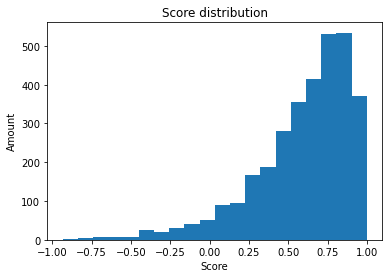

In [293]:
# calculate score
score = (df.total_positive - df.total_negative)/df.total_reviews

# plot distribution
plt.hist(score, bins=20)
plt.xlabel("Score")
plt.ylabel("Amount")
plt.title("Score distribution")


In [57]:
df["platforms"].loc[0]

"{'windows': True, 'mac': False, 'linux': False}"

In [60]:
literal_eval(str(df["platforms"].loc[0]).replace("''",'None'))["windows"]

True

In [67]:
def one_hot_encode_platforms(df):
    
    platforms = ["windows","mac","linux"]
    for platform in platforms:
        df[platform] = 0
    
    for index, row in df.iterrows():
        try:
            dict = literal_eval(str(row.platforms).replace("''",'None'))
        
        # if not possible delete row
        except: 
            df.drop(index, inplace=True)
            
        #dict[]
        for platform in platforms:
            if dict[platform]:
                df[platform].loc[index] = 1
    
    return df
        
        

In [68]:
one_hot_encode_platforms(df)

C:\Users\Marco\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,appid,name,review_score,total_positive,total_negative,total_reviews,type,required_age,is_free,short_description,...,Software Training,Sexual Content,Animation & Modeling,Action,Экшены,Nudity,Design & Illustration,windows,mac,linux
0,1648390,ScooterFlow,8,446,21,467,game,0,False,The world’s most realistic freestyle scooter g...,...,0,0,0,0,0,0,0,1,0,0
1,1648610,Malum,6,146,53,199,game,0,False,Malum is the premier C-list horror game. Run f...,...,0,0,0,1,0,0,0,1,0,0
2,1647962,Hell Let Loose – Lethal Tide,8,70,6,76,dlc,0,False,Unlock access to the Lethal Tide DLC.,...,0,0,0,1,0,0,0,1,0,0
3,1647550,NEO: The World Ends with You,8,224,11,235,game,0,False,&quot;Only the possibility of you can change o...,...,0,0,0,1,0,0,0,1,0,0
4,1647730,Zool Redimensioned,8,68,2,70,game,0,False,The Ninja of the Nth Dimension is back! Explor...,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2431,3510,Amazing Adventures: The Lost Tomb,8,44,9,53,game,0,False,You are an adventure seeker who travels the wo...,...,0,0,0,0,0,0,0,1,0,0
2432,2800,X2: The Threat,6,142,38,180,game,0,False,X²: The Threat is of a new generation of space...,...,0,0,0,0,0,0,0,1,0,0
2433,17470,Dead Space (2008),8,8843,938,9781,game,0,False,"You are Isaac Clarke, an engineer on the space...",...,0,0,0,1,0,0,0,1,0,0
2434,758320,Cursed Lands,6,60,22,82,game,0,False,Defeat the evil lurking in Castle Of N'Mar in ...,...,0,0,0,0,0,0,0,1,1,1


In [ ]:
# experimental stuff. Needs discussion before proceeding!

In [52]:
def clean_catefories(df):
    # this function takes the API output of the column genres and cleans it up
    #genres are shown in a list in new column "genres_clean" in output dataframe
    
    df["categories_clean"] = ""
    
    # iterate through rows
    for index, row in df.iterrows():
            
        # try to read the entry as a dictionary
        try:
            dict = literal_eval(str(row.categories).replace("''",'None'))
        
        # if not possible delete row
        except: 
            df.drop(index, inplace=True)
        
        # if possible
        else:
             
            categories = []
            
            for j in range(len(dict)):
                categories.append(dict[j]["description"])
            
            df["categories_clean"].loc[index] = np.array(categories)
                    
    df.drop('categories', axis=1, inplace=True)
    df.reset_index(inplace=True)
    df.drop("index", axis=1, inplace=True)

    return df

In [53]:
clean_catefories(df)

C:\Users\Marco\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,level_0,appid,name,review_score,total_positive,total_negative,total_reviews,type,required_age,is_free,...,Web Publishing,Game Development,Software Training,Sexual Content,Animation & Modeling,Action,Экшены,Nudity,Design & Illustration,categories_clean
0,0,1648390,ScooterFlow,8,446,21,467,game,0,False,...,0,0,0,0,0,0,0,0,0,[Single-player]
1,1,1648610,Malum,6,146,53,199,game,0,False,...,0,0,0,0,0,1,0,0,0,"[Single-player, Multi-player, Co-op, Online Co..."
2,2,1647962,Hell Let Loose – Lethal Tide,8,70,6,76,dlc,0,False,...,0,0,0,0,0,1,0,0,0,"[Multi-player, PvP, Online PvP, Downloadable C..."
3,3,1647550,NEO: The World Ends with You,8,224,11,235,game,0,False,...,0,0,0,0,0,1,0,0,0,"[Single-player, Steam Achievements, Full contr..."
4,4,1647730,Zool Redimensioned,8,68,2,70,game,0,False,...,0,0,0,0,0,1,0,0,0,"[Single-player, Steam Achievements, Partial Co..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2418,2431,3510,Amazing Adventures: The Lost Tomb,8,44,9,53,game,0,False,...,0,0,0,0,0,0,0,0,0,[Single-player]
2419,2432,2800,X2: The Threat,6,142,38,180,game,0,False,...,0,0,0,0,0,0,0,0,0,"[Single-player, Captions available, Steam Cloud]"
2420,2433,17470,Dead Space (2008),8,8843,938,9781,game,0,False,...,0,0,0,0,0,1,0,0,0,"[Single-player, Full controller support, Steam..."
2421,2434,758320,Cursed Lands,6,60,22,82,game,0,False,...,0,0,0,0,0,0,0,0,0,"[Single-player, Steam Achievements, Steam Cloud]"


In [55]:
def get_categories_set(df):
    # this function iterates through the new column "genres_clean" and return the set of unique genres contained in the dataframe
    G = []
    
    for idx,row in df.iterrows():
        
        for j in range(len(row.categories_clean)):
            G.append(row.categories_clean[j])
    
    return list(set(G))
        

In [56]:
get_categories_set(df)

['Shared/Split Screen',
 'In-App Purchases',
 'Remote Play на телефоне',
 'Online PvP',
 'Remote Play on Tablet',
 'Online Co-op',
 'Stats',
 'Коллекционные карточки',
 'Мастерская Steam',
 'LAN PvP',
 'Multi-player',
 'VR Supported',
 'Partial Controller Support',
 'Remote Play on TV',
 'Remote Play on Phone',
 'SteamVR Collectibles',
 'Steam Turn Notifications',
 'Steam Leaderboards',
 'Steam Cloud',
 'Tracked Controller Support',
 'Remote Play на планшете',
 'Steam Trading Cards',
 'Shared/Split Screen Co-op',
 'LAN Co-op',
 'VR Only',
 'Remote Play Together',
 'Статистика',
 'Downloadable Content',
 'Includes Source SDK',
 'Remote Play на телевизоре',
 'Cross-Platform Multiplayer',
 'Co-op',
 'Контроллер (полностью)',
 'Для нескольких игроков',
 'Full controller support',
 'Includes level editor',
 'VR Support',
 'MMO',
 'Покупки внутри приложения',
 'Captions available',
 'Single-player',
 'Commentary available',
 'Mods',
 'Steam Workshop',
 'Valve Anti-Cheat enabled',
 'Достижени

In [ ]:
# maybe isolate Singeplayer, Multiplayer, Shared/Split Screen Co-op, Co-op, Online Co-op, Online PvP, Shared/Split Screen, MMO

In [ ]:
# how to encode Age?, Add relase date as ordinal data?(if yes, encode how?)